# Problem 4. 

Suppose that one car is moving from A (x,y,θ) = (3,15,0) to B (x,y,θ) = (23,1,0) and the other car is
moving from B to A in the same environment, starting at the same time. Their equations of motion are
identical to Prob. 2. They do not communicate with each other, but can sense moving objects within the
radius of 3 from their own position, except those occluded by static obstacles. The safety regulation is to
keep the minimum distance of 1 between the cars (in addition to obstacle avoidance as before).
Use any methods to compute their efficient trajectories. For example, you can combine the result from
Prob. 3 and the potential function.

pure-pursuit part of the code based on AtsushiSakai's code

link : https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathTracking/pure_pursuit/pure_pursuit.py

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import matplotlib.patches as patches
import math

In [142]:
occ_map = np.array([[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1],
            [0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0,0,0,1],
            [1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1],
            [1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1],
            [0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1],
            [0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1],
            [0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1]])

a_star_grid_path = np.array([(0, 2), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 4), (8, 5), (8, 6), (7, 7), (6, 8), (5, 9), (4, 10), (3, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 15), (7, 15), (8, 15), (9, 15), (10, 15), (11, 16), (11, 17), (11, 18), (10, 19), (10, 20), (11, 21), (12, 22), (13, 22), (14, 22)])
a_star_path = np.array([[j+0.5, i+0.5] for i, j in a_star_grid_path])

In [143]:
occ_map.shape[0], occ_map.shape[1]

(15, 25)

In [144]:
def is_occupied(x, y):
    if x <= 0 or x >= occ_map.shape[1] or y <= 0 or y >= occ_map.shape[0]:
        return True
    return occ_map[int(occ_map.shape[0] - y), int(x)] == 1

In [145]:
# Parameters
lookahead_distance = 0.8 # [m] look-ahead distance
Kp = 1.0  # speed proportional gain
dt = 0.01  # [s] time tick

In [159]:
class State:
    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=1.0, w=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.w = w

    def update(self,v,w):
        self.v = v;
        self.w = w;
        self.x += v * math.cos(self.yaw) * dt
        self.y += v * math.sin(self.yaw) * dt
        self.yaw = np.mod(self.yaw + w * dt + np.pi, 2 * np.pi) - np.pi

    def calc_distance(self, point_x, point_y):
        dx = self.x - point_x
        dy = self.y - point_y
        return math.hypot(dx, dy)

In [147]:
class States:
    def __init__(self):
        self.x = []
        self.y = []
        self.yaw = []
        self.v = []
        self.w = []
        self.t = []

    def append(self, t, state):
        self.x.append(state.x)
        self.y.append(state.y)
        self.yaw.append(state.yaw)
        self.v.append(state.v)
        self.w.append(state.w)
        self.t.append(t)

In [148]:
class FollowPath:
    def __init__(self, path):
        self.path_x = path[:,0]
        self.path_y= path[:,1]
        self.old_nearest_point_index = None

    def initialize_index(self):
        self.old_nearest_point_index = None
        
    def search_target_index(self, state):
        # To speed up nearest point search, doing it at only first time.
        if self.old_nearest_point_index is None:
            # search nearest point index
            dx = [state.x - icx for icx in self.path_x]
            dy = [state.y - icy for icy in self.path_y]
            d = np.hypot(dx, dy)
            ind = np.argmin(d)
            self.old_nearest_point_index = ind
        else:
            ind = self.old_nearest_point_index
            distance_this_index = state.calc_distance(self.path_x[ind],self.path_y[ind])
            while True:
                if ind + 1 >= len(self.path_x):
                    break
                distance_next_index = state.calc_distance(self.path_x[ind + 1],self.path_y[ind + 1])
                if distance_this_index < distance_next_index:
                    break
                ind = ind + 1 if (ind + 1) < len(self.path_x) else ind
                distance_this_index = distance_next_index
            self.old_nearest_point_index = ind

        # search look ahead target point index
        while lookahead_distance > state.calc_distance(self.path_x[ind], self.path_y[ind]):
            if (ind + 1) >= len(self.path_x):
                break  # not exceed goal
            ind += 1

        return ind

In [171]:
def pure_pursuit_steer_control(state, trajectory, pind, target_speed=0.1):

    ind = trajectory.search_target_index(state)
    
    if pind >= ind:
        ind = pind

    if ind < len(trajectory.path_x)-1:
        tx = trajectory.path_x[ind]
        ty = trajectory.path_y[ind]
    else:  # toward goal
        tx = trajectory.path_x[-1]
        ty = trajectory.path_y[-1]
        ind = len(trajectory.path_x) - 1

    yaw_difference = math.atan2(ty - state.y, tx - state.x) - state.yaw
    yaw_difference = (yaw_difference + np.pi) % (2 * np.pi) - np.pi

    # If diff > pi, it means we need to go the negative route to be shorter
    if yaw_difference > np.pi:
        yaw_difference -= 2 * np.pi

    # yaw_difference = math.atan2(ty - state.y, tx - state.x) - state.yaw

    # if(abs(yaw_difference) > abs(yaw_difference - 2*math.pi)):
    #     yaw_difference = 2 * math.pi - yaw_difference
    # if(abs(yaw_difference) > abs(2*math.pi + yaw_difference)):
    #     yaw_difference = 2 * math.pi + yaw_difference
    
    w = yaw_difference / math.pi # w in [-1. 1]
    v = target_speed

    return v,w, ind

In [150]:
def draw_path(states_a, states_b):
    plt.plot(states_a.x, states_a.y, "-b", label="trajectory A")
    plt.plot(states_b.x, states_b.y, "-g", label="trajectory B")

In [194]:
def pfm_control(state, path, obstacle):
    def calculate_exponential_wall_potential(x, y):
        min_dist_to_obstacle = np.inf
        for i in range(occ_map.shape[1]):
            for j in range(occ_map.shape[0]):
                if is_occupied(i, j):
                    dist = np.sqrt((x - i) ** 2 + (y - j) ** 2)
                    if dist < min_dist_to_obstacle:
                        min_dist_to_obstacle = dist

        return 100 * np.exp(-(min_dist_to_obstacle-1) * 10)
    
    def calculate_potential(x,y):
        goal_potential = math.hypot(x - path[-1,0], y - path[-1,1])
        # static_obstacle_potential = calculate_exponential_wall_potential(x, y)
        static_obstacle_potential = 100 if is_occupied(x, y) else 0
        # static_obstacle_potential = 0
        dist_to_dynamic_obstacle = math.hypot(x - obstacle.x, y - obstacle.y)
        dynamic_obstacle_potential = 100 if dist_to_dynamic_obstacle < 1 else 100*np.exp(-(dist_to_dynamic_obstacle-1)*50)
        return goal_potential + static_obstacle_potential + dynamic_obstacle_potential
    
    def gradient(x, y, scale=1):
        delta = 0.1
        dx = (
            calculate_potential(x + delta, y) - calculate_potential(x - delta, y)
        ) / (2 * delta)
        dy = (
            calculate_potential(x, y + delta) - calculate_potential(x, y - delta)
        ) / (2 * delta)
        dx = 0.1 if dx > 0.1 else -0.1 if dx < -0.1 else dx
        dy = 0.1 if dy > 0.1 else -0.1 if dy < -0.1 else dy
        return dx, dy
    
    dx, dy = gradient(state.x, state.y)
    return dx, dy


In [195]:
def collision_free_path_planning(path_a, path_b):
    target_velocity = 0.05
    T = 500.0 
    time = 0.0

    states_a = States()
    states_b = States()

    state_a = State(x=path_a[0,0], y=path_a[0,1], yaw=0.0, v=0.0, w=0.0)
    state_b = State(x=path_b[0,0], y=path_b[0,1], yaw=0.0, v=0.0, w=0.0)
    states_a.append(time, state_a)
    states_b.append(time, state_b)

    target_course_a = FollowPath(path_a)
    target_course_b = FollowPath(path_b)
    
    target_ind_a = target_course_a.search_target_index(state_a)
    target_ind_b = target_course_b.search_target_index(state_b)
    
    while time <= T:
        # check if goal is reached
        goal_reached_a = state_a.calc_distance(path_a[-1,0], path_a[-1,1]) < 0.1
        goal_reached_b = state_b.calc_distance(path_b[-1,0], path_b[-1,1]) < 0.1
        if goal_reached_a and goal_reached_b:
            return states_a, states_b
        
        if goal_reached_a:
            print("A has arrived at goal")
            state_a.update(0,0)
            v_b, w_b, target_ind_b = pure_pursuit_steer_control(state_b, target_course_b, target_ind_b, target_speed=0.2)
            state_b.update(v_b, w_b)
        
        elif goal_reached_b:
            print("B has arrived at goal")
            state_b.update(0,0)
            v_a, w_a, target_ind_a = pure_pursuit_steer_control(state_a, target_course_a, target_ind_a, target_speed=0.2)
            state_a.update(v_a, w_a)
        
        
        # check if two robots are aware of each other
        elif state_a.calc_distance(state_b.x, state_b.y) < 3.0:
            target_course_a.initialize_index()
            target_course_b.initialize_index()
            
            dx_a, dy_a = pfm_control(state_a, path_a, state_b)
            dx_b, dy_b = pfm_control(state_b, path_b, state_a)
            state_a.x=state_a.x - 0.1 * dx_a
            state_a.y=state_a.y - 0.1 * dy_a
            state_b.x=state_b.x - 0.1 * dx_b
            state_b.y=state_b.y - 0.1 * dy_b
        
        else:
            v_a, w_a, target_ind_a = pure_pursuit_steer_control(state_a, target_course_a, target_ind_a, target_speed=0.1)
            v_b, w_b, target_ind_b = pure_pursuit_steer_control(state_b, target_course_b, target_ind_b, target_speed=0.2)
            state_a.update(v_a, w_a)  # Control vehicle
            state_b.update(v_b, w_b)  # Control vehicle
            

        states_a.append(time, state_a)
        states_b.append(time, state_b)
        
        # draw_path(states_a, states_b)
        # fig.canvas.draw()
        # plt.pause(dt)
        
        time += dt

    print("Time over.")
    return states_a, states_b
    

B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arrived at goal
B has arri

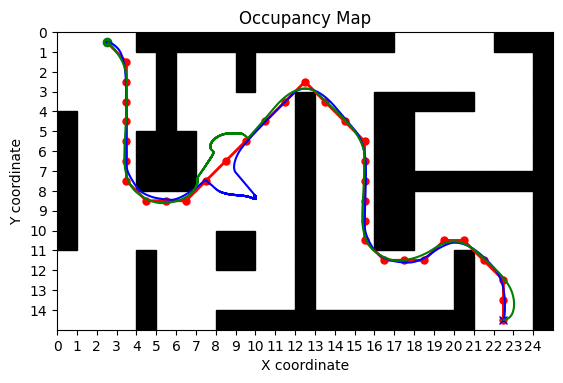

In [196]:
## Plot everything
fig, ax = plt.subplots()
# Create a figure and an axes
ax.set_aspect('equal')
ax.margins(0)
ax.invert_yaxis()  # Invert the y-axis so that the first row of the grid is at the top

# Display the occupancy grid
for i in range(occ_map.shape[0]):
    for j in range(occ_map.shape[1]):
        if occ_map[i][j] == 1:
            # Adding a rectangle for each occupied cell
            ax.add_patch(patches.Rectangle((j, i), 1, 1, color='black'))

plt.plot(a_star_path[:,0], a_star_path[:,1], 'ro-', linewidth=2, markersize=5, label='Path')  # 'ro-' for red line with circle markers
plt.plot(a_star_path[0,0], a_star_path[0,1], 'go', label='Start')  # Mark the start with a green circle
plt.plot(a_star_path[-1,0], a_star_path[-1,1], 'bx', label='Goal')  # Mark the end with a blue 'x'

states_a, states_b = collision_free_path_planning(a_star_path, a_star_path[::-1])
plt.plot(states_a.x, states_a.y, "-b", label="trajectory A")
plt.plot(states_b.x, states_b.y, "-g", label="trajectory B")

# Adding labels and a title for clarity
ax.set_title('Occupancy Map')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

ax.set_xticks(np.arange(0, occ_map.shape[1], 1))
ax.set_yticks(np.arange(0, occ_map.shape[0], 1))
# ax.invert_yaxis()  # Invert the y-axis so that the first row of the grid is at the top
# Show the plot

plt.show()

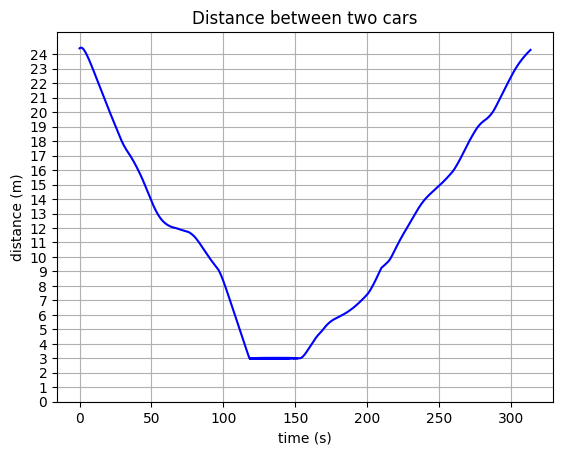

In [197]:
fig, ax = plt.subplots()
dist_between_robots = np.zeros(len(states_a.t))
for i in range(len(states_b.t)):
    dist_between_robots[i] = np.sqrt((states_a.x[i] - states_b.x[i])**2 + (states_a.y[i] - states_b.y[i])**2)
plt.plot(states_a.t, dist_between_robots, "-b", label="trajectory A")
# Adding labels and a title for clarity
ax.set_title('Distance between two cars')
ax.set_xlabel('time (s)')
ax.set_ylabel('distance (m)')

ax.set_yticks(np.arange(0,25, 1))
plt.grid()